# **Transformer Interpretability Beyond Attention Visualization**

In [ ]:
!git clone -q https://github.com/hila-chefer/Transformer-Explainability.git

import os

!pip install -q zennit
!git clone -q https://github.com/Kejmer/Quantus
os.chdir(f'Quantus')
import zennit
import quantus
os.chdir('..')

os.chdir(f'./Transformer-Explainability')


!pip install pip --upgrade
!pip install -q einops
!pip install -q lime
!pip install -q shap
# os.chdir('..')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 1.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 kB 39.7 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from modules.layers_ours import Linear
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import cv2
import gdown

In [ ]:
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1I3wM54pN9oEikNkxc-rIDzZaR3VswS7P", # may need to change id after 'id='
    'model_best.pth.tar'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I3wM54pN9oEikNkxc-rIDzZaR3VswS7P
To: /content/Transformer-Explainability/model_best.pth.tar
100%|██████████| 1.03G/1.03G [00:24<00:00, 42.0MB/s]


'model_best.pth.tar'

In [ ]:
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1pMOkUrprtM7-s6Ny_kA-bzSw-BD7klZS", # may need to change id after 'id='
    'lungs_samples.zip'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1pMOkUrprtM7-s6Ny_kA-bzSw-BD7klZS
To: /content/Transformer-Explainability/lungs_samples.zip
100%|██████████| 2.67M/2.67M [00:00<00:00, 222MB/s]


'lungs_samples.zip'

In [ ]:
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1eXlovBOixEswqHKE3md9lysb1YmQr4QA", # may need to change id after 'id='
    'samples/covid_221.png'
)
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1bN-wmWaeYOnx3xqJTanzsMXgQ7StkHWY", # may need to change id after 'id='
    'samples/non_COVID (498).png'
)
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=18f2KCNKkSmFb4O6KGwJgJRwN5ryEKouR", # may need to change id after 'id='
    'samples/Normal (1926).png'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1eXlovBOixEswqHKE3md9lysb1YmQr4QA
To: /content/Transformer-Explainability/samples/covid_221.png
100%|██████████| 27.6k/27.6k [00:00<00:00, 47.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1bN-wmWaeYOnx3xqJTanzsMXgQ7StkHWY
To: /content/Transformer-Explainability/samples/non_COVID (498).png
100%|██████████| 30.2k/30.2k [00:00<00:00, 19.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=18f2KCNKkSmFb4O6KGwJgJRwN5ryEKouR
To: /content/Transformer-Explainability/samples/Normal (1926).png
100%|██████████| 29.4k/29.4k [00:00<00:00, 62.0MB/s]


'samples/Normal (1926).png'

In [ ]:
#@title Lungs class indices to names
%%capture
CLS2IDX = {0: 'COVID-19', 1: 'Non-COVID', 2: 'Normal'}

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

# **ViT examples**

In [ ]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
unnormalize = transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    )
inv_transform = transforms.Compose([
    transforms.ToTensor(),
    unnormalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP().cuda()
model.head = Linear(model.head.in_features, 3).cuda()
model.load_state_dict(torch.load('/content/Transformer-Explainability/model_best.pth.tar')['state_dict'])
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, with_img=True, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution) if with_img else transformer_attribution
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_k_classes(k, predictions, **kwargs):    
    # Print Top-k predictionsfrom modules.layers_ours import
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(k, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print(f'Top {k} classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

def preprocess_image(image_path):
    image = np.asarray(Image.open(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = Image.fromarray(image, mode="RGB")
    return image
    

In [ ]:
def visualize_LRP(image_path, with_img=True):
    image = preprocess_image(image_path)
    trans_image = transform(image)

    fig, axs = plt.subplots(1, 4, figsize=(15, 15))
    axs[0].imshow(image);
    axs[0].axis('off');
    axs[0].title.set_text('Original')

    output = model(trans_image.unsqueeze(0).cuda())
    print_top_k_classes(3, output)

    # covid
    covid = generate_visualization(trans_image, with_img=with_img, class_index=0)

    # non covid
    noncovid = generate_visualization(trans_image, with_img=with_img, class_index=1)

    # normal
    normal = generate_visualization(trans_image, with_img=with_img, class_index=2)


    axs[1].imshow(covid);
    axs[1].axis('off');
    axs[1].title.set_text('Covid')
    axs[2].imshow(noncovid);
    axs[2].axis('off');
    axs[2].title.set_text('Non-Covid')
    axs[3].imshow(normal);
    axs[3].axis('off');
    axs[3].title.set_text('Normal')

# Lime

In [ ]:
from lime import lime_image

In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [ ]:
test_pred = batch_predict([pill_transf(preprocess_image('samples/covid_221.png'))]) 
test_pred.squeeze().argmax()

0

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(preprocess_image('samples/non_COVID (498).png'))), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=2000) # number of images that will be sent to classification function

  0%|          | 0/2000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
explanation.top_labels

[1, 2, 0]

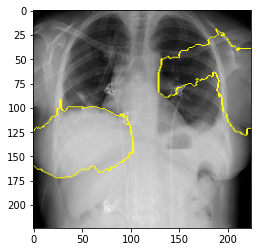

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

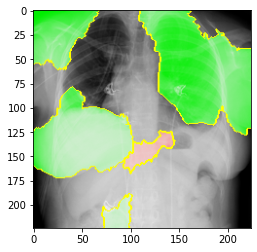

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

# SZYMON zacząłem tutaj

In [ ]:
def get_image_paths(dir):
  return [os.path.join(dir, filename) for filename in os.listdir(dir)]

def preprocess_batch(list_of_xes, cls):
  targets = torch.Tensor(len(list_of_xes)*[cls]).long()
  images = [preprocess_image(x) for x in list_of_xes]
  trans_images = [transform(image) for image in images]
  return torch.stack(trans_images), targets

import einops

def generate_lrp_goodformat(x_batch):
  vis = np.stack([generate_visualization(x, with_img=False) for x in x_batch])
  vis = einops.rearrange(vis,"b h w c -> b c h w")
  return vis

def generate_visualization_lime(path, explainer, with_img=True):
    explanation = explainer.explain_instance(np.array(pill_transf(preprocess_image(path))), 
                                            batch_predict, # classification function
                                            top_labels=3, 
                                            hide_color=0, 
                                            num_samples=200) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
    return mark_boundaries(temp/255.0, mask) if with_img else einops.repeat(mask, "h w -> h w c", c=3)

def generate_lime(x_batch):
    explainer = lime_image.LimeImageExplainer()
    vis = np.stack([generate_visualization_lime(x, explainer, with_img=False) for x in x_batch])
    vis = einops.rearrange(vis,"b h w c -> b c h w")
    return vis


## pobierz dane z mojego kochanego drive

In [ ]:
!unzip -q "/content/Transformer-Explainability/lungs_samples.zip"

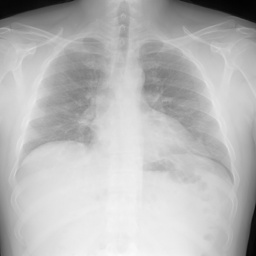

In [ ]:
example_path= "/content/Transformer-Explainability/lung_samples/COVID-19/covid_10.png"
Image.open(example_path)

wygląda ok

In [ ]:
from copy import deepcopy as copy

In [ ]:
def take_first_3_indices_from_mask(mask):
  for i,val in enumerate(mask):
    if val == True:
      break
  mask_copy = copy(mask)
  mask_copy[i+3:] = False
  return mask_copy

weź batcha 87 zdjęć, ale to za dużo, więc weź po 3 zdjęcia z każdej klasy do szybkiego prototypowania

## wczytaj dane, masz indeksy dla każdej klasy zdefiniowane

In [ ]:
covid_dir = "/content/Transformer-Explainability/lung_samples/COVID-19"
noncovid_dir = "/content/Transformer-Explainability/lung_samples/Non-COVID"
healthy_dir = "/content/Transformer-Explainability/lung_samples/Normal"

covid_paths =  get_image_paths(covid_dir)
noncovid_paths = get_image_paths(noncovid_dir)
healthy_paths = get_image_paths(healthy_dir)

x_batches,y_batches = [],[]
x_batch_lime = []
for path, class_number in zip([covid_paths,noncovid_paths,healthy_paths],[0,1,2]):
  x_batch,y_batch = preprocess_batch(path,class_number)
  x_batches.append(x_batch)
  y_batches.append(y_batch)
  x_batch_lime.extend(path)

x_batch = torch.cat(x_batches)
y_batch = torch.cat(y_batches)


# full class indices
covid_indices,noncovid_indices,healthy_indices = y_batch==0, y_batch==1, y_batch==2

# sample class indices
baby_covid_idx = take_first_3_indices_from_mask(covid_indices)
baby_noncovid_idx = take_first_3_indices_from_mask(noncovid_indices)
baby_healthy_idx = take_first_3_indices_from_mask(healthy_indices)

#baby_sample_all_x i y to są te sample po 3 zdj z klasy
baby_sample_all_x = torch.cat([x_batch[idx] for idx in [baby_covid_idx,baby_noncovid_idx,baby_healthy_idx]])
baby_sample_all_y = torch.cat([y_batch[idx] for idx in [baby_covid_idx,baby_noncovid_idx,baby_healthy_idx]])

żeby działało w explanations, trzeba dać do numpy, ale generate_lrp_goodformat bierze torch Tensor

### baby batch

In [ ]:
np_sample_x_batch = baby_sample_all_x.numpy()
np_sample_y_batch = baby_sample_all_y.numpy()
np_sample_a_batch = generate_lrp_goodformat(baby_sample_all_x) # argument is not numpy

In [ ]:
device="cuda"
faithfullness_estimator = quantus.FaithfulnessEstimate(
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
    similarity_func=quantus.similarity_func.correlation_pearson,
    features_in_step=224,  
    perturb_baseline="white",
)

Warnings and information:
 (1) The Faithfulness Estimate metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and similarity function 'similarity_func'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability with self-explaining neural networks.' arXiv preprint arXiv:1806.07538 (2018).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



In [ ]:
baby_estimate = faithfullness_estimator(model=model, 
   x_batch=np_sample_x_batch, 
   y_batch=np_sample_y_batch,
   a_batch=np_sample_a_batch,
   device=device,
)

/content/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


In [ ]:
baby_estimate

[0.07019323249953262,
 0.5218956314405616,
 0.46744782938126545,
 -0.22169708737009386,
 0.48871214469688856,
 -0.006319492325384434,
 0.5466251733264705,
 0.3469124103150195,
 0.7161329224124965]

### bigboi batch

In [ ]:
np_x_batch = x_batch.numpy()
np_y_batch = y_batch.numpy()
np_a_batch = generate_lrp_goodformat(x_batch) # argument is not numpy
np_a_batch_lime = generate_lime(x_batch_lime)

In [ ]:
bigboi_estimate = faithfullness_estimator(model=model, 
   x_batch=np_x_batch, 
   y_batch=np_y_batch,
   a_batch=np_a_batch,
   device=device,
)
bigboi_estimate_lime = faithfullness_estimator(model=model, 
   x_batch=np_x_batch, 
   y_batch=np_y_batch,
   a_batch=np_a_batch_lime,
   device=device,
)

/content/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


In [ ]:
bigboi_estimate = np.array(bigboi_estimate)
bigboi_estimate_lime = np.array(bigboi_estimate_lime)

In [ ]:
bigboi_estimate.mean(), bigboi_estimate_lime.mean()

(0.2652855467199742, 0.06786151122246471)

Text(0.5, 1.0, 'Faithfulness Estimation (LRP)')

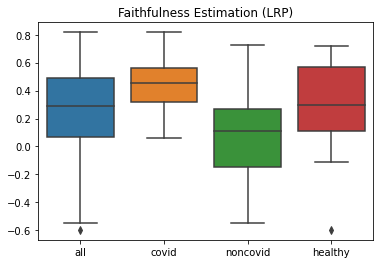

In [ ]:
import numpy as np
import seaborn as sns

np.random.seed(111)
covid_estimate = bigboi_estimate[covid_indices]
noncovid_estimate = bigboi_estimate[noncovid_indices]
healthy_estimate = bigboi_estimate[healthy_indices]

all_arr = [bigboi_estimate,covid_estimate,noncovid_estimate,healthy_estimate]
sns.boxplot(data=all_arr)

plt.xticks(np.arange(4),["all","covid","noncovid","healthy"])
plt.title("Faithfulness Estimation (LRP)")

Text(0.5, 1.0, 'Faithfulness Estimation (LIME)')

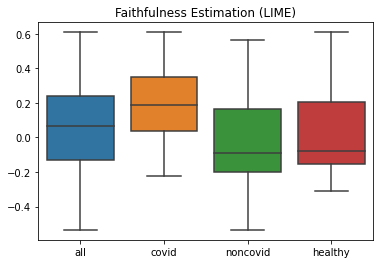

In [ ]:
covid_estimate_lime = bigboi_estimate_lime[covid_indices]
noncovid_estimate_lime = bigboi_estimate_lime[noncovid_indices]
healthy_estimate_lime = bigboi_estimate_lime[healthy_indices]

all_arr_lime = [bigboi_estimate_lime,covid_estimate_lime,noncovid_estimate_lime,healthy_estimate_lime]
sns.boxplot(data=all_arr_lime)

plt.xticks(np.arange(4),["all","covid","noncovid","healthy"])
plt.title("Faithfulness Estimation (LIME)")

<ipython-input-190-0a9f9a86100c>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(np.arange(4), ["all","covid","noncovid","healthy"])
<ipython-input-190-0a9f9a86100c>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(np.arange(4), ["all","covid","noncovid","healthy"])


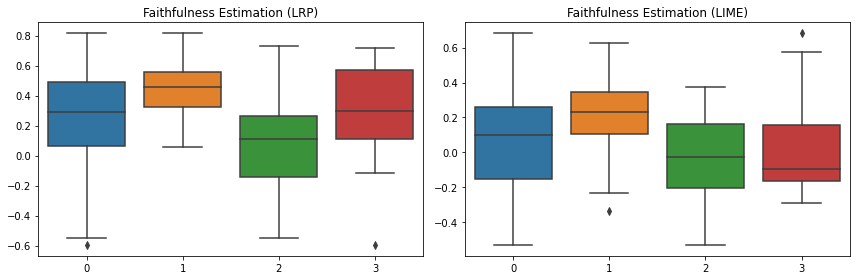

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(111)
covid_estimate = bigboi_estimate[covid_indices]
noncovid_estimate = bigboi_estimate[noncovid_indices]
healthy_estimate = bigboi_estimate[healthy_indices]

all_arr = [bigboi_estimate,covid_estimate,noncovid_estimate,healthy_estimate]

covid_estimate_lime = bigboi_estimate_lime[covid_indices]
noncovid_estimate_lime = bigboi_estimate_lime[noncovid_indices]
healthy_estimate_lime = bigboi_estimate_lime[healthy_indices]

all_arr_lime = [bigboi_estimate_lime,covid_estimate_lime,noncovid_estimate_lime,healthy_estimate_lime]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=all_arr, ax=ax[0])
ax[0].set_xticks(np.arange(4), ["all","covid","noncovid","healthy"])
ax[0].set_title("Faithfulness Estimation (LRP)")

sns.boxplot(data=all_arr_lime, ax=ax[1])
ax[1].set_xticks(np.arange(4), ["all","covid","noncovid","healthy"])
ax[1].set_title("Faithfulness Estimation (LIME)")

fig.tight_layout()

In [ ]:
def calc_avg_sensitivity(a_batch_expl):
    step = 10
    avg_sensitivity_estimate_all = []
    avg_sensitivity_estimate = quantus.AvgSensitivity(
          nr_samples=2,
          lower_bound=0.2,
          norm_numerator=quantus.norm_func.fro_norm,
          norm_denominator=quantus.norm_func.fro_norm,
        #   perturb_func=quantus.perturb_func.uniform_noise,
          similarity_func=quantus.similarity_func.difference,
      )
    for i in range(0,90,step): # CUDA out of memory
        estimator = avg_sensitivity_estimate(model=model, 
            x_batch=np_x_batch[i:i+step], 
            y_batch=np_y_batch[i:i+step],
            a_batch=a_batch_expl[i:i+step, [0]],
            explain_func=quantus.explain,
            explain_func_kwargs={"method": "Saliency"},
            device=device,
            )
        avg_sensitivity_estimate_all = avg_sensitivity_estimate_all + estimator

    avg_sensitivity_estimate_all = np.array(avg_sensitivity_estimate_all)
    return avg_sensitivity_estimate_all

In [ ]:
avg_sensitivity_estimate = calc_avg_sensitivity(np_a_batch)
avg_sensitivity_estimate_lime = calc_avg_sensitivity(np_a_batch_lime)

Warnings and information:
 (1) The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the met

/content/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/content/Quantus/quantus/functions/explanation_func.py:92: UserWarning: Using quantus 'explain' function as an explainer without specifying 'attributor'in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(


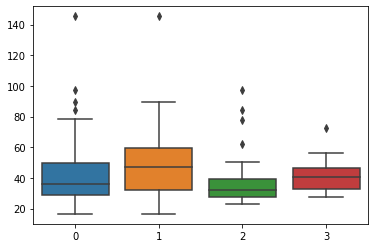

In [ ]:
import numpy as np
import seaborn as sns

np.random.seed(111)
covid_estimate = avg_sensitivity_estimate[covid_indices]
noncovid_estimate = avg_sensitivity_estimate[noncovid_indices]
healthy_estimate = avg_sensitivity_estimate[healthy_indices]

all_arr_sens = [avg_sensitivity_estimate,covid_estimate,noncovid_estimate,healthy_estimate]
sns.boxplot(data=all_arr_sens)

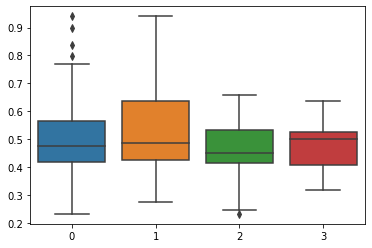

In [ ]:
import numpy as np
import seaborn as sns

np.random.seed(111)
covid_estimate = avg_sensitivity_estimate_lime[covid_indices]
noncovid_estimate = avg_sensitivity_estimate_lime[noncovid_indices]
healthy_estimate = avg_sensitivity_estimate_lime[healthy_indices]

all_arr_sens_lime = [avg_sensitivity_estimate_lime,covid_estimate,noncovid_estimate,healthy_estimate]
sns.boxplot(data=all_arr_sens_lime)

# Inspect explanations

Top 3 classes:
	0 : COVID-19 		value = 3.668	 prob = 97.7%
	1 : Non-COVID		value = -0.208	 prob = 2.0%
	2 : Normal   		value = -2.379	 prob = 0.2%


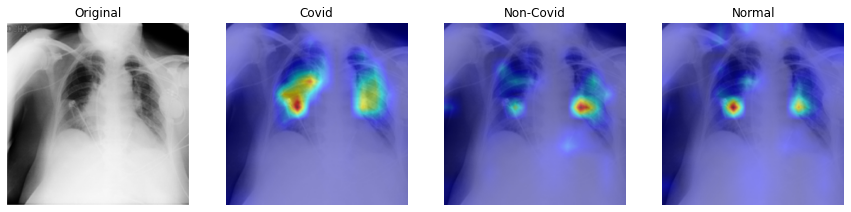

In [ ]:
#@title Covid
visualize_LRP('samples/covid_221.png')

Top 3 classes:
	1 : Non-COVID		value = 5.567	 prob = 99.9%
	2 : Normal   		value = -1.818	 prob = 0.1%
	0 : COVID-19 		value = -2.440	 prob = 0.0%


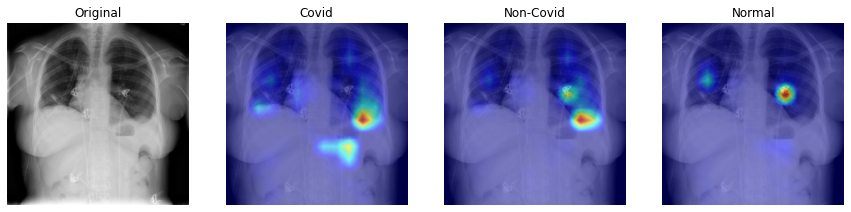

In [ ]:
#@title Non-Covid
visualize_LRP('samples/non_COVID (498).png')

Top 3 classes:
	2 : Normal   		value = 3.335	 prob = 95.3%
	1 : Non-COVID		value = 0.305	 prob = 4.6%
	0 : COVID-19 		value = -3.826	 prob = 0.1%


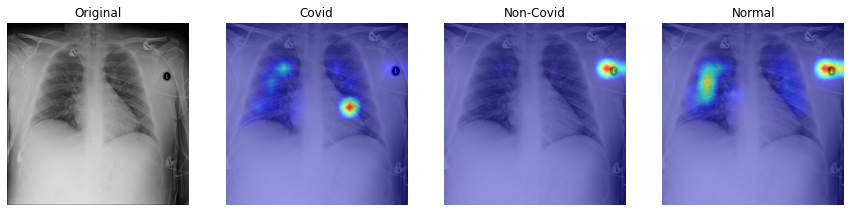

In [ ]:
#@title Normal
visualize_LRP('samples/Normal (1926).png')

# Grid

In [ ]:

!unzip /content/drive/MyDrive/xaio_zadyma_data/lung_samples2.zip -d lung_samples2

unzip:  cannot find or open /content/drive/MyDrive/xaio_zadyma_data/lung_samples2.zip, /content/drive/MyDrive/xaio_zadyma_data/lung_samples2.zip.zip or /content/drive/MyDrive/xaio_zadyma_data/lung_samples2.zip.ZIP.


In [ ]:
def create_grid(images_dir):
    images_list = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir)][8:11]
    
    fig, axs = plt.subplots(len(images_list), 6, figsize=(20, 10))
    
    for ind, (ax_row, image) in enumerate(zip(axs, images_list)):
        image = preprocess_image(image)

        # LRP
        trans_image = transform(image)
        output = model(trans_image.unsqueeze(0).cuda())
        print(f'image {ind}:')
        print_top_k_classes(3, output)

        # covid
        covid = generate_visualization(trans_image, class_index=0)

        # non covid
        noncovid = generate_visualization(trans_image, class_index=1)

        # normal
        normal = generate_visualization(trans_image, class_index=2)


        # LIME
        explanation = explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=300) # number of images that will be sent to classification function

        temp_small, mask_small = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
        temp_big, mask_big = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=False)

        boundry_small = mark_boundaries(temp_small/255.0, mask_small)
        boundry_big = mark_boundaries(temp_big/255.0, mask_big)

        to_visualize = [image, covid, noncovid, normal, boundry_small, boundry_big]
        names = ['Original', 'Covid', 'Non-covid', 'Normal', 'Lime (small)', 'Lime (big)']
        for ax_col, image_vis, name in zip(ax_row, to_visualize, names):
            ax_col.imshow(image_vis)
            ax_col.axis('off')
            if ind == 0:
                ax_col.title.set_text(name)
                ax_col.title.set_fontsize(20)

In [ ]:
create_grid('lung_samples2/lung_samples/COVID-19/')

In [ ]:
create_grid('lung_samples2/lung_samples/Non-COVID/')

In [ ]:
create_grid('lung_samples2/lung_samples/Normal/')